In [11]:
try:
	import google.colab
	IN_COLAB = True
except ImportError:
	IN_COLAB = False

if IN_COLAB:
	!pip install scikit-learn matplotlib numpy pandas torch pytorch-lightning torchvision tensorboardx tensorflow

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

from IPython.display import display
	# make it not fail in terminal execution

from torchvision import datasets
from torchvision.transforms.v2 import CenterCrop
from sklearn.model_selection import train_test_split

## Hyperparameter configuration, set random states

In [4]:
# hyperparameters
random_state = 42 # random state
test_val_size = 0.2 # size of test and validation together to the whole dataset
test_size = 0.5 # size of test to test and validation together
batch_size = 64 # batch size
num_workers = 2 # number of workers for data loading

is_celeba_on = False # celebA is needed or not

In [5]:
# Fix random early on
np.random.seed(random_state)
torch.manual_seed(random_state)

## Data modules

In [6]:
class CombinedDataset(torch.utils.data.Dataset):
	def __init__(self, datasets, transform=None):
		self.samples = []  # Store (image, label) pairs
		self.transform = transform

		for dataset in datasets:
			for i in range(len(dataset)):
				image, label = dataset[i]  # Access each image and label
				self.samples.append((image, label))

	def __len__(self):
		return len(self.samples)

	def __getitem__(self, idx):
		image, label = self.samples[idx]

		if self.transform:
			image = self.transform(image)

		return image, label

### Flowers Module

In [20]:
# Flowers data module
class FlowersDataModule(pl.LightningDataModule):
	def __init__(self):
		super().__init__()
		self.name = "Flowers102"
		self.base_transform = transforms.Compose([
				transforms.CenterCrop(500),
				transforms.Resize(64),
				transforms.ToTensor(),
				transforms.Lambda(lambda img: (img - 0.5) * 2)
		])
		self.reverse_transform = transforms.Compose([
				transforms.Lambda(lambda img: img / 2 + 0.5),
				transforms.Lambda(lambda img: img.permute(1, 2, 0).numpy() * 255),
				transforms.Lambda(lambda img: img.astype(np.uint8))
		])

		self.concat_dataset = torch.utils.data.ConcatDataset([
				datasets.Flowers102('./data', download=True, split="train"),
				datasets.Flowers102('./data', download=True, split="test"),
				datasets.Flowers102('./data', download=True, split="val")
		])

	def setup(self):
		self.dataset = CombinedDataset(datasets=self.concat_dataset.datasets, transform=self.base_transform)
		train, test_val = train_test_split(self.dataset, test_size=test_val_size, random_state=random_state)
		test, val = train_test_split(test_val, test_size=test_size, random_state=random_state)
		self.train_dataset = train
		self.val_dataset = val
		self.test_dataset = test

	def train_dataloader(self):
		return torch.utils.data.DataLoader(
				self.train_dataset,
				batch_size=batch_size,
				num_workers=num_workers,
				pin_memory=True,
				drop_last=True,
				shuffle=False,
		)

	def val_dataloader(self):
		return torch.utils.data.DataLoader(
				self.val_dataset,
				batch_size=batch_size,
				num_workers=num_workers,
				pin_memory=True,
				shuffle=False,
		)

	def test_dataloader(self):
		return DataLoader(
				self.test_dataset,
				batch_size=batch_size,
				num_workers=num_workers,
				pin_memory=True,
				shuffle=False,
		)

### CelebA Module

In [8]:
# Celeba data module: TODO need to convert
class CelebaDataModule(pl.LightningDataModule):
	def __init__(self, len_flowers_dataset):
		super().__init__()
		self.name = "CelebA"
		self.train_transform = transforms.Compose([
				# may add random transformation steps
				transforms.CenterCrop(178),
				transforms.Resize(64),
				transforms.ToTensor(),
				transforms.Lambda(lambda img: (img - 0.5) * 2)
		])
		self.val_transform = transforms.Compose([
				transforms.CenterCrop(178),
				transforms.Resize(64),
				transforms.ToTensor(),
				transforms.Lambda(lambda img: (img - 0.5) * 2)
		])
		self.reverse_transform = transforms.Compose([
				transforms.Lambda(lambda img: img / 2 + 0.5),
				transforms.Lambda(lambda img: img.permute(1, 2, 0).numpy() * 255),
				transforms.Lambda(lambda img: img.astype(np.uint8))
		])
		# To compare the model on a different dataset it should be the same size (currently 8k vs 200k)
		self.dataset = torch.utils.data.Subset(
				datasets.CelebA('./data', download=True, split="all"),
				np.random.choice(len_flowers_dataset, len_flowers_dataset, replace=False)
		)

	def setup(self):
		train, test_val = train_test_split(self.dataset, test_size=test_val_size, random_state=random_state)
		test, val = train_test_split(test_val, test_size=test_size, random_state=random_state)
		self.train_dataset = train.with_transform(self.preprocess_train)
		self.val_dataset = val.with_transform(self.preprocess_val)
		self.test_dataset = test

	def train_dataloader(self):
		return torch.utils.data.DataLoader(
				self.train_dataset,
				batch_size=batch_size,
				num_workers=num_workers,
				pin_memory=True,
				drop_last=True,
				shuffle=False,
		)

	def val_dataloader(self):
		return torch.utils.data.DataLoader(
				self.val_dataset,
				batch_size=batch_size,
				num_workers=num_workers,
				pin_memory=True,
				shuffle=False,
		)

	def test_dataloader(self):
		return DataLoader(
				self.test_dataset,
				batch_size=batch_size,
				num_workers=num_workers,
				pin_memory=True,
				shuffle=False,
		)

	def __preprocess_train(self, batch):
		batch["image"] = [self.train_transform(image) for image in batch["image"]]
		return batch

	def __preprocess_val(self, batch):
		batch["image"] = [self.val_transform(image) for image in batch["image"]]
		return batch

## DataModule creation

In [9]:
# Create data module instances
flowers_dm = FlowersDataModule()
if is_celeba_on:
	celeba_dm = CelebaDataModule(len(flowers_dm.dataset))

## Data visualization

In [11]:
# Show sizes of images
def analyze_size(imgs, text, cols=["height", "width", "channels"]):
	sizes = pd.DataFrame([np.array(img).shape for img, _ in imgs])
	sizes.columns = cols
	grouped_df = sizes.groupby(cols).size().reset_index(name='count')
	display(grouped_df.head())
	print(text, "min height", sizes["height"].min())
	print(text, "min width", sizes["width"].min())

analyze_size(flowers_dm.concat_dataset, flowers_dm.name)
if is_celeba_on:
	analyze_size(celeba_dm.concat_dataset, celeba_dm.name)

,height,width,channels,count
0,500,500,3,70
1,500,501,3,2
2,500,502,3,10
3,500,503,3,10
4,500,504,3,11


Flowers102 min height 500
Flowers102 min width 500


In [13]:
 # Show sizes of transformed images
def analyze_transformed(dataset, transform, text):
	dataset = [(transform(img), target) for img, target in dataset]
	analyze_size(dataset, text, ["channels", "height", "width"])
	images = np.array([np.array(img) for img, target in dataset])
	return images

flower_tensors = analyze_transformed(flowers_dm.concat_dataset, flowers_dm.base_transform, flowers_dm.name)
if is_celeba_on:
	celeba_tensors = analyze_transformed(celeba_dm.concat_dataset, celeba_dm.base_transform, celeba_dm.name)

,channels,height,width,count
0,3,64,64,8189


Flowers102 min height 64
Flowers102 min width 64


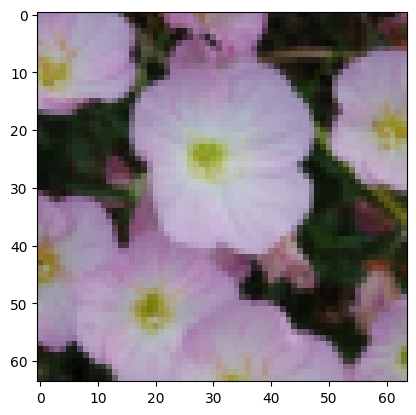

<Figure size 640x480 with 0 Axes>

In [14]:
# Transformed image visualization
plt.imshow(flowers_dm.reverse_transform(torch.from_numpy(flower_tensors[0])))
plt.figure()
if is_celeba_on:
	plt.imshow(celeba_dm.reverse_transform(torch.from_numpy(celeba_tensors[0])))

## Data analysis

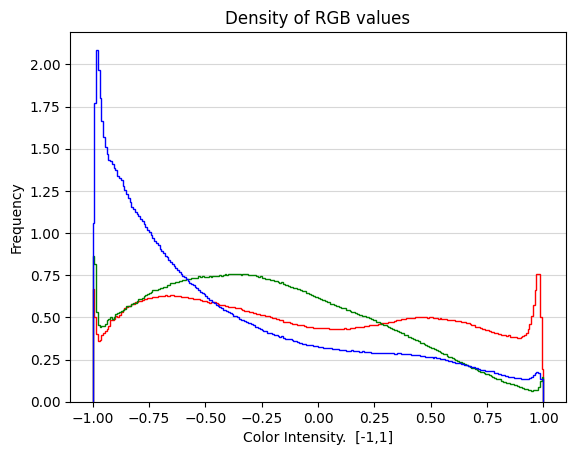

<Figure size 640x480 with 0 Axes>

In [15]:
# Distribution of (normalized) pixels
def img_histogram(data):
	for i, color in enumerate(["red", "green", "blue"]):
		plt.hist(data[:, i, :, :].flatten(), bins=256, range=(-1, 1), color=color, histtype=u'step', density=True)
	plt.title('Density of RGB values')
	plt.xlabel('Color Intensity.  [-1,1]')
	plt.ylabel('Frequency')
	plt.grid(axis='y', alpha=0.5)
	plt.show()

img_histogram(flower_tensors)
plt.figure()
if is_celeba_on:
	img_histogram(celeba_tensors)

In [16]:
# split tensor data to train, test, val
def split(dataset):
	train, test = train_test_split(dataset, test_size=test_val_size, random_state=42)
	test, val = train_test_split(test, test_size=test_size, random_state=42)
	print(train.shape)
	print(test.shape)
	print(val.shape)
	return train, test, val

flower_train, flower_test, flower_val = split(flower_tensors)

if is_celeba_on:
	celeba_train, celeba_test, celeba_val = split(celeba_tensors)

(6551, 3, 64, 64)
(819, 3, 64, 64)
(819, 3, 64, 64)


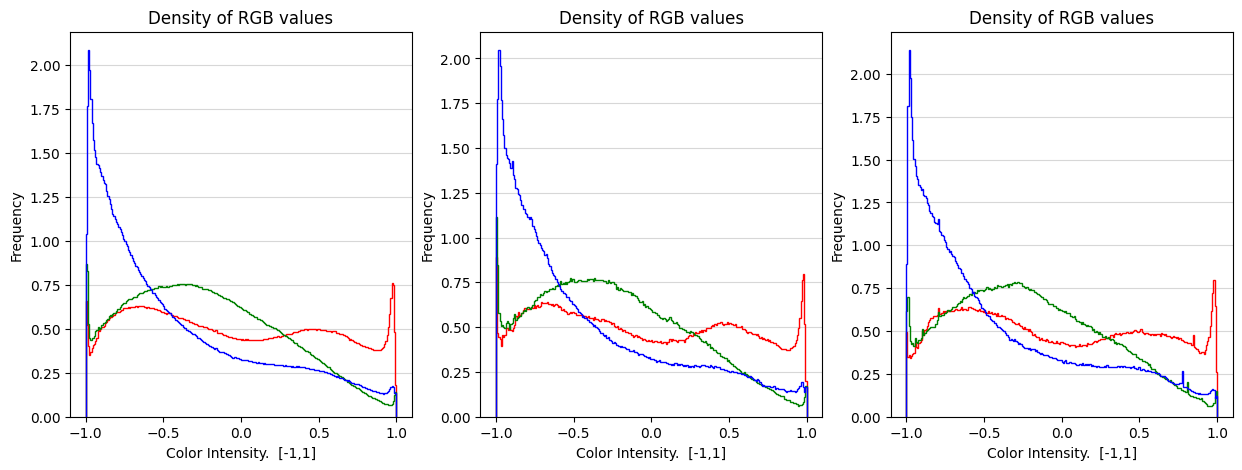

<Figure size 640x480 with 0 Axes>

In [ ]:
# Check if distribution is similar between train, test, val
def split_histogram(train, test, val):
	fig, axs = plt.subplots(1, 3, figsize=(15, 5))
	for idx, dataset in enumerate([train, test, val]):
		for i, color in enumerate(["red", "green", "blue"]):
			axs[idx].hist(dataset[:, i, :, :].flatten(), bins=256, range=(-1, 1), color=color, histtype=u'step', density=True)
		axs[idx].set_title('Density of RGB values') # can't use existing function because it's not .title 🙃
		axs[idx].set_xlabel('Color Intensity.  [-1,1]') # ...
		axs[idx].set_ylabel('Frequency') # ...
		axs[idx].grid(axis='y', alpha=0.5)
	plt.show()

split_histogram(flower_train, flower_test, flower_val)
plt.figure()
if is_celeba_on:
	split_histogram(celeba_train, celeba_test, celeba_val)

In [18]:
del flower_tensors, flower_train, flower_test, flower_val
if is_celeba_on:
	del celeba_tensors, celeba_train, celeba_test, celeba_val

## Create data loaders

In [19]:
flowers_dm.prepare_data()
flowers_dm.setup()

if is_celeba_on:
	celeba_dm.prepare_data()
	celeba_dm.setup()

In [ ]:
# gyakorlat: docker hogyan
# cleansing (kép szórás eloszlás, kicsik kidobása)

# keresztvalidáció
# min max scaler csak tanítótól függjön!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# todo: fix random
# baseline legyen mintavételezés az eloszlásból
# vae baseline, test on own gpu

# T db gauss zaj hozzáadás: várh érték függ az előző képtől?: https://huggingface.co/blog/annotated-diffusion
# variancia változik minden üzemben (~learning rate schedule)
# lehetne hiperparaméter a beta scheduler is (lineáris, exponenciális)

# Releváns laborok: Gépi labor 4. VAE
# Jó levezetés: https://lilianweng.github.io/posts/2021-07-11-diffusion-models/